In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2
import shutil
import os
import seaborn as sns


from tensorflow.keras import applications 
from keras.applications import MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import Sequence




In [52]:
# Load CSV file
train_df = pd.read_csv(r"train.csv")  

# Display shape and first few rows
print("Dataset Shape:", train_df.shape)
train_df.head()

Dataset Shape: (3662, 2)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: >

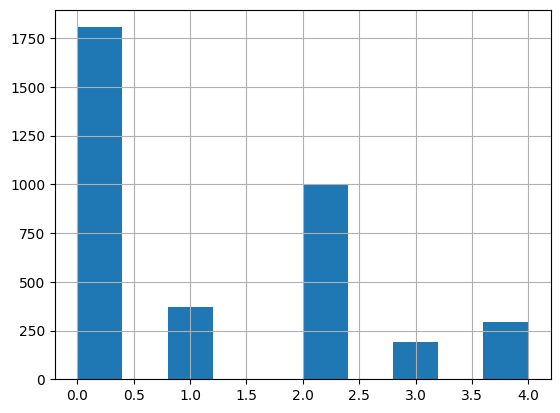

In [53]:
train_df['diagnosis'].value_counts()
train_df['diagnosis'].hist()

In [58]:
import os

folder_path = "gaussian_filtered_images/gaussian_filtered_images"

for subfolder in os.listdir(folder_path):
    if subfolder == ".ipynb_checkpoints":
        continue  # Skip this file/folder

    subfolder_path = os.path.join(folder_path, subfolder)
    print(f"Processing: {subfolder_path}")


Processing: gaussian_filtered_images/gaussian_filtered_images\export.pkl
Processing: gaussian_filtered_images/gaussian_filtered_images\Mild
Processing: gaussian_filtered_images/gaussian_filtered_images\Moderate
Processing: gaussian_filtered_images/gaussian_filtered_images\No_DR
Processing: gaussian_filtered_images/gaussian_filtered_images\Proliferate_DR
Processing: gaussian_filtered_images/gaussian_filtered_images\Severe


Subfolders: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


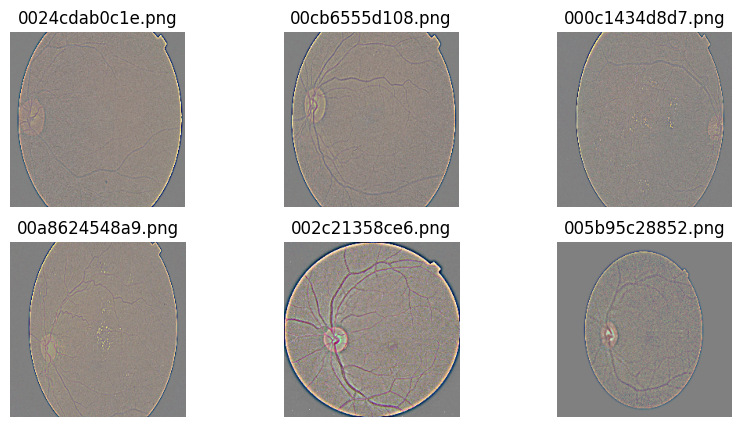

In [63]:
base_folder = "gaussian_filtered_images/gaussian_filtered_images"  # Update based on your folder

# List subfolders inside 'gaussian', excluding unwanted files/folders
subfolders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f)) and not f.startswith('.')]

print("Subfolders:", subfolders)

# Collect image paths from subfolders
image_paths = []
for subfolder in subfolders:
    subfolder_path = os.path.join(base_folder, subfolder)
    
    # Filter only image files (ignoring hidden/system files)
    image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in image_files[:2]:  # Take first 2 images per subfolder
        image_paths.append(os.path.join(subfolder_path, img_file))

# Display images
plt.figure(figsize=(10, 5))
for i, img_path in enumerate(image_paths[:6]):  # Show up to 6 images
    img = cv2.imread(img_path)
    
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    else:
        print(f"Error loading: {img_path}")

plt.show()


In [55]:


# Define the base path to dataset
BASE_PATH = 'gaussian_filtered_images/gaussian_filtered_images'

# Load the dataset (Update the file path)
df = pd.read_csv("train.csv")  # Replace with actual path

# Split dataset into training (80%) and validation (20%) with balanced labels
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['diagnosis'])

# Resize function
def resize_image(image):
    return cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)

# Normalize function
def normalize_image(image):
    image = resize_image(image)
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Function to find the correct image path inside subfolders
def find_image_path(image_name):
    for folder in ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']:
        img_path = os.path.join(BASE_PATH, folder, f"{image_name}.png")
        if os.path.exists(img_path):
            return img_path
    return None  # If image is not found

# Custom Data Generator to load images in batches
class ImageDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        x_batch = np.empty((len(batch_df), 224, 224, 3), dtype=np.float32)
        y_batch = batch_df['diagnosis'].values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = find_image_path(row['id_code'])
            if img_path:
                image = cv2.imread(img_path)
                image = normalize_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                x_batch[i] = image
            else:
                print(f" Warning: Image {row['id_code']}.png not found!")

        return x_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Initialize data generators for training and validation
train_generator = ImageDataGenerator(train_df, batch_size=32)
val_generator = ImageDataGenerator(val_df, batch_size=32)

# Print number of batches
print(f" Training Batches: {len(train_generator)}")
print(f" Validation Batches: {len(val_generator)}")

# Example: Fetch a single batch to test
x_batch, y_batch = train_generator[0]
print(" Batch Data Shape:", x_batch.shape)
print(" Batch Labels Shape:", y_batch.shape)


 Training Batches: 91
 Validation Batches: 22
 Batch Data Shape: (32, 224, 224, 3)
 Batch Labels Shape: (32,)


In [56]:


# Extract all images and labels from train_generator
x_train = []
y_train = []

for i in range(len(train_generator)):  # Iterate over all batches
    x_batch, y_batch = train_generator[i]
    x_train.append(x_batch)
    y_train.append(y_batch)

# Convert list to NumPy arrays
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(f" x_train shape: {x_train.shape}")
print(f" y_train shape: {y_train.shape}")


 x_train shape: (2912, 224, 224, 3)
 y_train shape: (2912,)


In [20]:


BATCH_SIZE = 8

data_generator = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=360,  
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)

# Ensure Data Generator is properly assigned
train_data = data_generator.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=42)


In [39]:
# Extract validation data from val_generator
x_val = []
y_val = []

for i in range(len(val_generator)):  # Iterate over all batches
    x_batch, y_batch = val_generator[i]
    x_val.append(x_batch)
    y_val.append(y_batch)

# Convert list to NumPy arrays
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

print(f" x_val shape: {x_val.shape}")
print(f" y_val shape: {y_val.shape}")

# Save for later use
np.save("x_val.npy", x_val)
np.save("y_val.npy", y_val)

print(" x_val.npy and y_val.npy saved successfully!")


 x_val shape: (704, 224, 224, 3)
 y_val shape: (704,)
 x_val.npy and y_val.npy saved successfully!


In [23]:

class Metrics(Callback):
  def __init__(self, validation_data):
    self.validation_data = validation_data

  def on_train_begin(self, logs={}):
    self.val_kappas = []

  def on_epoch_end(self, epoch, logs={}):
    X_val, y_val = self.validation_data[:2]

    # Convert inputs to numpy arrays
    X_val = np.array(X_val)
    y_val = np.array(y_val).astype(int)

    # Get predictions and ensure they are integers
    y_pred = np.argmax(self.model.predict(X_val), axis=1).astype(int)

    # Compute Kappa Score
    _val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

    logs["val_kappa"] = _val_kappa
    print(f"val_kappa: {_val_kappa}")

    
kappa_metrics = Metrics([x_val, y_val])

In [24]:


# Load MobileNetV2 with valid parameters
mobilenet = MobileNetV2(
    alpha=1.0,  # MobileNetV2 only supports 0.35, 0.5, 0.75, 1.0, 1.4
    weights='imagenet',  # Use ImageNet pre-trained weights
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers (optional for transfer learning)
mobilenet.trainable = False

# Define the model
model = Sequential([
    mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')  # Change activation if needed
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Updated Adam syntax
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,652,997 (10.12 MB)

 Trainable params: 395,013 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
history = model.fit(
    train_generator,  
    steps_per_epoch=len(train_generator),  # Use the length of the generator
    epochs=10,
    validation_data=val_generator,  #  Use validation generator directly
    callbacks=[kappa_metrics]
)



Epoch 1/10


C:\Users\Shakthi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.6540 - loss: 1.0595 
val_kappa: 0.6985250965941081
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 374ms/step - accuracy: 0.6545 - loss: 1.0577 - val_accuracy: 0.7330 - val_loss: 0.7816 - val_kappa: 0.6985
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.7491 - loss: 0.6959 
val_kappa: 0.7124765950290619
91/91 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.7491 - loss: 0.6958 - val_accuracy: 0.7599 - val_loss: 0.7030 - val_kappa: 0.7125
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.7640 - loss: 0.6415 
val_kappa: 0.6998647255196708
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.7640 - loss: 0.6414 - val_accuracy: 0.7528 - val_loss: 0.7017 - val_kappa: 0.6999
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7766 - loss: 0.5886 
val_kappa: 0.737854665803702
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.7766 - loss: 0.5887 - val_accuracy: 0.7599 - val_loss: 0.7045 - val_kappa:

In [27]:
model.save("models/my_model.keras")
print("Saved")


Saved


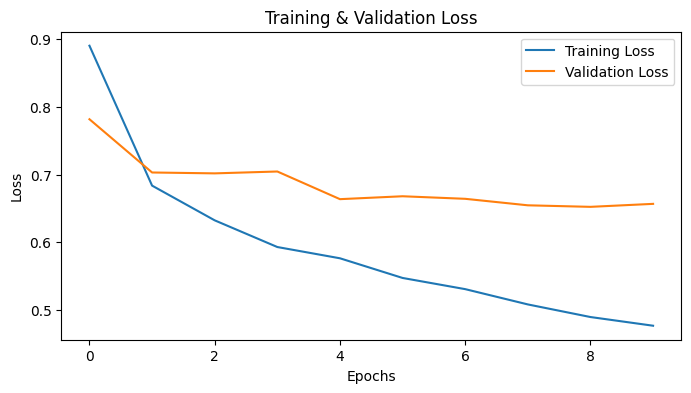

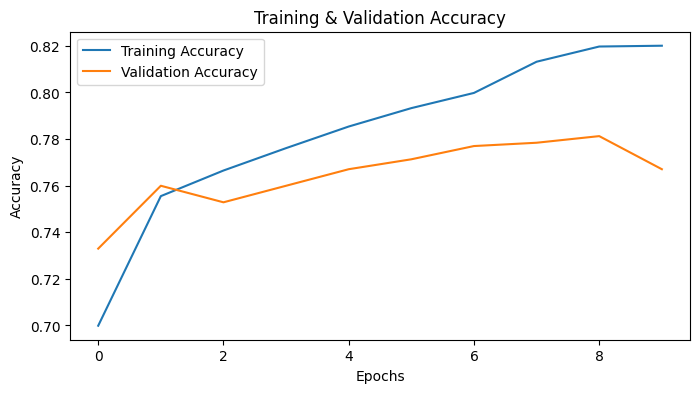

In [28]:
# Convert history object to DataFrame
history_df = pd.DataFrame(history.history)

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# Save history to CSV
history_df.to_csv('history.csv', index=False)


In [40]:
# Ensure the model is already trained before running this
y_val_pred_probs = model.predict(x_val, batch_size=BATCH_SIZE)  # Predict probabilities
y_val_pred = np.argmax(y_val_pred_probs, axis=1)  # Get predicted class labels

# Compute Cohen's Kappa Score
kappa_val = cohen_kappa_score(
    y_val.astype(int),  # Convert to int if not already
    y_val_pred, 
    weights='quadratic'
)

print(f"\n VALIDATION KAPPA SCORE: {kappa_val:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step

 VALIDATION KAPPA SCORE: 0.7788


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step 


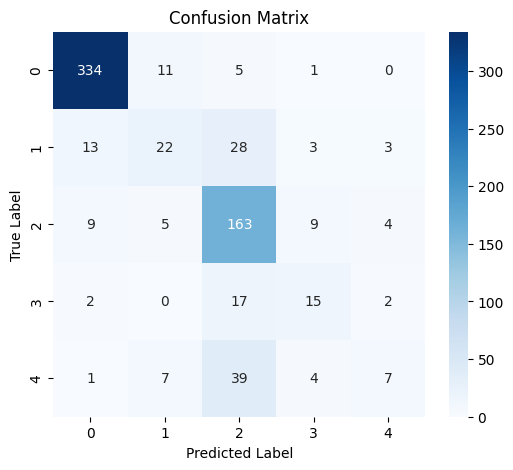

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       351
           1       0.49      0.32      0.39        69
           2       0.65      0.86      0.74       190
           3       0.47      0.42      0.44        36
           4       0.44      0.12      0.19        58

    accuracy                           0.77       704
   macro avg       0.59      0.53      0.54       704
weighted avg       0.75      0.77      0.74       704



In [44]:


# Get model predictions on validation set
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Display Confusion Matrix using Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred_classes))


In [41]:


# Load the saved model
model = tf.keras.models.load_model("models/my_model.keras")
print(" Model Loaded Successfully!")

# Define class labels
class_labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Function to preprocess the input image
def preprocess_image(img_path):
    image = cv2.imread(img_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image / 255.0  # Normalize to range [0,1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to predict class of an image
def predict_image(img_path):
    image = preprocess_image(img_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)  # Get class with highest probability
    confidence = np.max(prediction) * 100  # Get confidence percentage

    print(f" Image: {img_path}")
    print(f" Predicted Class: {class_labels[predicted_class]}")
    print(f" Confidence: {confidence:.2f}%")

    # Show the image
    plt.imshow(cv2.imread(img_path)[..., ::-1])  # Convert BGR to RGB for display
    plt.axis("off")
    plt.title(f"Prediction: {class_labels[predicted_class]} ({confidence:.2f}%)")
    plt.show()



 Model Loaded Successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
 Image: gaussian_filtered_images/gaussian_filtered_images/Mild/0a61bddab956.png
 Predicted Class: Mild
 Confidence: 50.23%


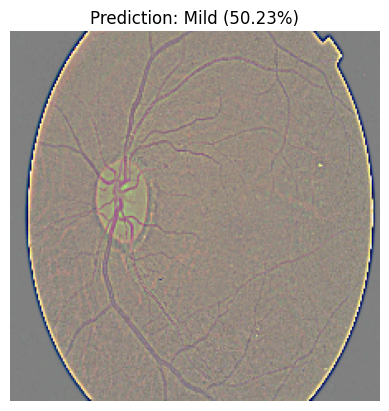

In [42]:

img_path = "gaussian_filtered_images/gaussian_filtered_images/Mild/0a61bddab956.png"  
predict_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
 Image: gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0e0fc1d9810c.png
 Predicted Class: Proliferative DR
 Confidence: 49.34%


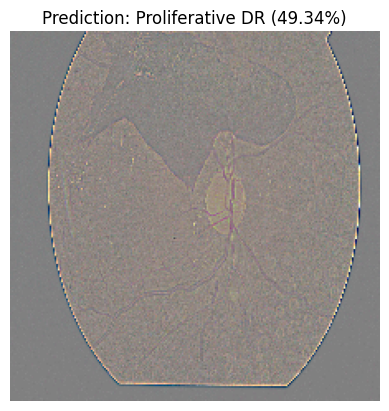

In [66]:
img_path = "gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0e0fc1d9810c.png"  # Replace with actual image path
predict_image(img_path)
